# Installs

In [1]:
!pip install --upgrade open_spiel

In [2]:
!pip install torch==1.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
Looking in links: https


# Reinforcement Learning Class

## RL Environment

In [3]:
# Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Reinforcement Learning (RL) Environment for Open Spiel.

This module wraps Open Spiel Python interface providing an RL-friendly API. It
covers both turn-based and simultaneous move games. Interactions between agents
and the underlying game occur mostly through the `reset` and `step` methods,
which return a `TimeStep` structure (see its docstrings for more info).

The following example illustrates the interaction dynamics. Consider a 2-player
Kuhn Poker (turn-based game). Agents have access to the `observations` (a dict)
field from `TimeSpec`, containing the following members:
 * `info_state`: list containing the game information state for each player. The
   size of the list always correspond to the number of players. E.g.:
   [[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]].
 * `legal_actions`: list containing legal action ID lists (one for each player).
   E.g.: [[0, 1], [0]], which corresponds to actions 0 and 1 being valid for
   player 0 (the 1st player) and action 0 being valid for player 1 (2nd player).
 * `current_player`: zero-based integer representing the player to make a move.

At each `step` call, the environment expects a singleton list with the action
(as it's a turn-based game), e.g.: [1]. This (zero-based) action must correspond
to the player specified at `current_player`. The game (which is at decision
node) will process the action and take as many steps necessary to cover chance
nodes, halting at a new decision or final node. Finally, a new `TimeStep`is
returned to the agent.

Simultaneous-move games follow analogous dynamics. The only differences is the
environment expects a list of actions, one per player. Note the `current_player`
field is "irrelevant" here, admitting a constant value defined in spiel.h, which
defaults to -2 (module level constant `SIMULTANEOUS_PLAYER_ID`).

See open_spiel/python/examples/rl_example.py for example usages.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import enum
from absl import logging
import numpy as np

import pyspiel

SIMULTANEOUS_PLAYER_ID = pyspiel.PlayerId.SIMULTANEOUS

class TimeStep(
    collections.namedtuple(
        "TimeStep", ["observations", "rewards", "discounts", "step_type"])):
  """Returned with every call to `step` and `reset`.

  A `TimeStep` contains the data emitted by a game at each step of interaction.
  A `TimeStep` holds an `observation` (list of dicts, one per player),
  associated lists of `rewards`, `discounts` and a `step_type`.

  The first `TimeStep` in a sequence will have `StepType.FIRST`. The final
  `TimeStep` will have `StepType.LAST`. All other `TimeStep`s in a sequence will
  have `StepType.MID.

  Attributes:
    observations: a list of dicts containing observations per player.
    rewards: A list of scalars (one per player), or `None` if `step_type` is
      `StepType.FIRST`, i.e. at the start of a sequence.
    discounts: A list of discount values in the range `[0, 1]` (one per player),
      or `None` if `step_type` is `StepType.FIRST`.
    step_type: A `StepType` enum value.
  """
  __slots__ = ()

  def first(self):
    return self.step_type == StepType.FIRST

  def mid(self):
    return self.step_type == StepType.MID

  def last(self):
    return self.step_type == StepType.LAST

  def is_simultaneous_move(self):
    return self.observations["current_player"] == SIMULTANEOUS_PLAYER_ID

  def current_player(self):
    return self.observations["current_player"]


class StepType(enum.Enum):
  """Defines the status of a `TimeStep` within a sequence."""

  FIRST = 0  # Denotes the first `TimeStep` in a sequence.
  MID = 1  # Denotes any `TimeStep` in a sequence that is not FIRST or LAST.
  LAST = 2  # Denotes the last `TimeStep` in a sequence.

  def first(self):
    return self is StepType.FIRST

  def mid(self):
    return self is StepType.MID

  def last(self):
    return self is StepType.LAST


# Global pyspiel members
def registered_games():
  return pyspiel.registered_games()



class ChanceEventSampler(object):
  """Default sampler for external chance events."""

  def __init__(self, seed=None):
    self.seed(seed)

  def seed(self, seed=None):
    self._rng = np.random.RandomState(seed)

  def __call__(self, state):
    """Sample a chance event in the given state."""
    actions, probs = zip(*state.chance_outcomes())
    return self._rng.choice(actions, p=probs)


class ObservationType(enum.Enum):
  """Defines what kind of observation to use."""
  OBSERVATION = 0  # Use observation_tensor
  INFORMATION_STATE = 1  # Use information_state_tensor


class Environment(object):
  """Open Spiel reinforcement learning environment class."""

  def __init__(self,
               game,
               discount=1.0,
               chance_event_sampler=None,
               observation_type=None,
               include_full_state=False,
               distribution=None,
               mfg_population=None,
               enable_legality_check=False,
               **kwargs):
    """Constructor.

    Args:
      game: [string, pyspiel.Game] Open Spiel game name or game instance.
      discount: float, discount used in non-initial steps. Defaults to 1.0.
      chance_event_sampler: optional object with `sample_external_events` method
        to sample chance events.
      observation_type: what kind of observation to use. If not specified, will
        default to INFORMATION_STATE unless the game doesn't provide it.
      include_full_state: whether or not to include the full serialized
        OpenSpiel state in the observations (sometimes useful for debugging).
      distribution: the distribution over states if the game is a mean field
        game.
      mfg_population: The Mean Field Game population to consider.
      enable_legality_check: Check the legality of the move before stepping.
      **kwargs: dict, additional settings passed to the Open Spiel game.
    """
    self._chance_event_sampler = chance_event_sampler or ChanceEventSampler()
    self._include_full_state = include_full_state
    self._distribution = distribution
    self._mfg_population = mfg_population
    self._enable_legality_check = enable_legality_check

    if isinstance(game, str):
      if kwargs:
        game_settings = {key: val for (key, val) in kwargs.items()}
        logging.info("Using game settings: %s", game_settings)
        self._game = pyspiel.load_game(game, game_settings)
      else:
        logging.info("Using game string: %s", game)
        self._game = pyspiel.load_game(game)
    else:  # pyspiel.Game or API-compatible object.
      logging.info("Using game instance: %s", game.get_type().short_name)
      self._game = game

    self._num_players = self._game.num_players()
    self._state = None
    self._should_reset = True

    # Discount returned at non-initial  steps.
    self._discounts = [discount] * self._num_players

    # Determine what observation type to use.
    if observation_type is None:
      if self._game.get_type().provides_information_state_tensor:
        observation_type = ObservationType.INFORMATION_STATE
      else:
        observation_type = ObservationType.OBSERVATION

    # Check the requested observation type is supported.
    if observation_type == ObservationType.OBSERVATION:
      if not self._game.get_type().provides_observation_tensor:
        raise ValueError(f"observation_tensor not supported by {game}")
    elif observation_type == ObservationType.INFORMATION_STATE:
      if not self._game.get_type().provides_information_state_tensor:
        raise ValueError(f"information_state_tensor not supported by {game}")
    self._use_observation = (observation_type == ObservationType.OBSERVATION)

    if self._game.get_type().dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD:
      assert distribution is not None
      assert mfg_population is not None
      assert 0 <= mfg_population < self._num_players

  def seed(self, seed=None):
    self._chance_event_sampler.seed(seed)

  def get_time_step(self):
    """Returns a `TimeStep` without updating the environment.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature": [],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    rewards = []
    step_type = StepType.LAST if self._state.is_terminal() else StepType.MID
    self._should_reset = step_type == StepType.LAST
    cur_rewards = self._state.rewards()
    for player_id in range(self.num_players):
      rewards.append(cur_rewards[player_id])
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"] = self._state.num_nodes
    observations["global_feature"] = self._state.global_feature
    observations["current_player"] = self._state.current_player()
    discounts = self._discounts
    if step_type == StepType.LAST:
      # When the game is in a terminal state set the discount to 0.
      discounts = [0. for _ in discounts]

    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)

    return TimeStep(
        observations=observations,
        rewards=rewards,
        discounts=discounts,
        step_type=step_type)

  def _check_legality(self, actions):
    if self.is_turn_based:
      legal_actions = self._state.legal_actions()
      if actions[0] not in legal_actions:
        raise RuntimeError(f"step() called on illegal action {actions[0]}")
    else:
      for p in range(len(actions)):
        legal_actions = self._state.legal_actions(p)
        if legal_actions and actions[p] not in legal_actions:
          raise RuntimeError(f"step() by player {p} called on illegal " +
                             f"action: {actions[p]}")

  def step(self, actions):
    """Updates the environment according to `actions` and returns a `TimeStep`.

    If the environment returned a `TimeStep` with `StepType.LAST` at the
    previous step, this call to `step` will start a new sequence and `actions`
    will be ignored.

    This method will also start a new sequence if called after the environment
    has been constructed and `reset` has not been called. Again, in this case
    `actions` will be ignored.

    Args:
      actions: a list containing one action per player, following specifications
        defined in `action_spec()`.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    assert len(actions) == self.num_actions_per_step, (
        "Invalid number of actions! Expected {}".format(
            self.num_actions_per_step))
    if self._should_reset:
      return self.reset()

    if self._enable_legality_check:
      self._check_legality(actions)

    if self.is_turn_based:
      self._state.apply_action(actions[0])
    else:
      self._state.apply_actions(actions)
    self._sample_external_events()

    return self.get_time_step()

  def reset(self):
    """Starts a new sequence and returns the first `TimeStep` of this sequence.

    Returns:
      A `TimeStep` namedtuple containing:
        observations: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        rewards: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discounts: list of discounts in the range [0, 1], or None if step_type
          is `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    self._should_reset = False
    if self._game.get_type(
    ).dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD and self._num_players > 1:
      self._state = self._game.new_initial_state_for_population(
          self._mfg_population)
    else:
      self._state = self._game.new_initial_state()
    self._sample_external_events()

    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature":[],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    for player_id in range(self.num_players):
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"]= self._state.num_nodes
    observations["global_feature"]= self._state.global_feature
    observations["current_player"] = self._state.current_player()
    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)
    return TimeStep(
        observations=observations,
        rewards=None,
        discounts=None,
        step_type=StepType.FIRST)

  def _sample_external_events(self):
    """Sample chance events until we get to a decision node."""
    while self._state.is_chance_node() or (self._state.current_player()
                                           == pyspiel.PlayerId.MEAN_FIELD):
      if self._state.is_chance_node():
        outcome = self._chance_event_sampler(self._state)
        self._state.apply_action(outcome)
      if self._state.current_player() == pyspiel.PlayerId.MEAN_FIELD:
        dist_to_register = self._state.distribution_support()
        dist = [
            self._distribution.value_str(str_state, default_value=0.0)
            for str_state in dist_to_register
        ]
        self._state.update_distribution(dist)

  def observation_spec(self):
    """Defines the observation per player provided by the environment.

    Each dict member will contain its expected structure and shape. E.g.: for
    Kuhn Poker {"info_state": (6,), "legal_actions": (2,), "current_player": (),
                "serialized_state": ()}

    Returns:
      A specification dict describing the observation fields and shapes.
    """
    return dict(
        info_state=(),
        num_nodes=(),
        global_feature=(),
        legal_actions=(self._game.num_distinct_actions(),),
        current_player=(),
        serialized_state=(),
    )

  def action_spec(self):
    """Defines per player action specifications.

    Specifications include action boundaries and their data type.
    E.g.: for Kuhn Poker {"num_actions": 2, "min": 0, "max":1, "dtype": int}

    Returns:
      A specification dict containing per player action properties.
    """
    return dict(
        num_actions=self._game.num_distinct_actions(),
        min=0,
        max=self._game.num_distinct_actions() - 1,
        dtype=int,
    )

  # Environment properties
  @property
  def use_observation(self):
    """Returns whether the environment is using the game's observation.

    If false, it is using the game's information state.
    """
    return self._use_observation

  # Game properties
  @property
  def name(self):
    return self._game.get_type().short_name

  @property
  def num_players(self):
    return self._game.num_players()

  @property
  def num_actions_per_step(self):
    return 1 if self.is_turn_based else self.num_players

  # New RL calls for more advanced use cases (e.g. search + RL).
  @property
  def is_turn_based(self):
    return ((self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.SEQUENTIAL) or
            (self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.MEAN_FIELD))

  @property
  def max_game_length(self):
    return self._game.max_game_length()

  @property
  def is_chance_node(self):
    return self._state.is_chance_node()

  @property
  def game(self):
    return self._game

  def set_state(self, new_state):
    """Updates the game state."""
    assert new_state.get_game() == self.game, (
        "State must have been created by the same game.")
    self._state = new_state

  @property
  def get_state(self):
    return self._state

## Replay Buffer

In [4]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Replay buffer of fixed size with a FIFI replacement policy."""

import random


class ReplayBuffer(object):
  """ReplayBuffer of fixed size with a FIFO replacement policy.
  Stored transitions can be sampled uniformly.
  The underlying datastructure is a ring buffer, allowing 0(1) adding and
  sampling.
  """

  def __init__(self, replay_buffer_capacity):
    self._replay_buffer_capacity = replay_buffer_capacity
    self._data = []
    self._next_entry_index = 0

  def add(self, element):
    """Adds `element` to the buffer.
    If the buffer is full, the oldest element will be replaced.
    Args:
      element: data to be added to the buffer.
    """
    if len(self._data) < self._replay_buffer_capacity:
      self._data.append(element)
    else:
      self._data[self._next_entry_index] = element
      self._next_entry_index += 1
      self._next_entry_index %= self._replay_buffer_capacity

  def sample(self, num_samples):
    """Returns `num_samples` uniformly sampled from the buffer.
    Args:
      num_samples: `int`, number of samples to draw.
    Returns:
      An iterable over `num_samples` random elements of the buffer.
    Raises:
      ValueError: If there are less than `num_samples` elements in the buffer
    """
    if len(self._data) < num_samples:
      raise ValueError("{} elements could not be sampled from size {}".format(
          num_samples, len(self._data)))
    return random.sample(self._data, num_samples)

  def reset(self):
    """Resets the contents of the replay buffer."""
    self._data = []
    self._next_entry_index = 0

  def __len__(self):
    return len(self._data)

  def __iter__(self):
    return iter(self._data)

## DQN PyTorch

In [5]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""DQN agent implemented in PyTorch."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import numpy as np
from scipy import sparse
from torch._C import dtype
import torch
from torch import nn
from torch_geometric import nn as gnn
from torch.nn import functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch.nn import Flatten, Linear
from torch_geometric.utils import convert

from open_spiel.python import rl_agent
#from open_spiel.python.utils.replay_buffer import ReplayBuffer

Transition = collections.namedtuple(
    "Transition", "info_state global_feature action reward next_info_state next_global_feature is_final_step legal_actions_mask")

ILLEGAL_ACTION_LOGITS_PENALTY = -1e9


class GraphNN(nn.Module):
  """A simple network built from nn.linear layers."""

  def __init__(self,
               feature_size,
               hidden_sizes,global_size):
    """Create the MLP.
    Args:
      input_size: (int) number of inputs
      hidden_sizes: (list) sizes (number of units) of each hidden layer
      output_size: (int) number of outputs
      activate_final: (bool) should final layer should include a ReLU
    """
    super(GraphNN, self).__init__()
    self.conv1 = GATv2Conv(feature_size, hidden_sizes[0],add_self_loops = True) 
    self.conv1bn = gnn.BatchNorm(hidden_sizes[0])
    self.conv2 = GATv2Conv(hidden_sizes[0],hidden_sizes[1],add_self_loops = True) 
    self.conv2bn = gnn.BatchNorm(hidden_sizes[1])
    self.linear1 = nn.Linear(hidden_sizes[1]+global_size,hidden_sizes[2]+global_size)
    self.batchnorm = nn.BatchNorm1d(hidden_sizes[2]+global_size)
    self.linear2 = nn.Linear(hidden_sizes[2]+global_size, 1)
  
  def forward(self, node_feature, edge_index, global_x):
    x, edge_index = node_feature, edge_index
    #global_x = global_x.repeat(x.size()[0],1)
    x = F.relu(self.conv1(x, edge_index))
    x = self.conv1bn(x)
    x = F.relu(self.conv2(x, edge_index))
    x = self.conv2bn(x)
    #x = F.relu(self.linear1(torch.hstack((x,global_x))))
    x = F.relu(self.linear1(x))
    x = self.batchnorm(x)
    x = F.relu(self.linear2(x))
    x = torch.softmax(x,dim=0)
    return x


class DQN(rl_agent.AbstractAgent):
  """DQN Agent implementation in PyTorch.
  See open_spiel/python/examples/breakthrough_dqn.py for an usage example.
  """

  def __init__(self,
               player_id,
               state_representation_size,
               global_feature_size,
               num_actions,
               hidden_layers_sizes=[5,5,3],
               output_layer_size =1,
               replay_buffer_capacity=10000,
               batch_size=128,
               replay_buffer_class=ReplayBuffer,
               learning_rate=0.001,
               update_target_network_every=1000,
               learn_every=10,
               discount_factor=1.0,
               min_buffer_size_to_learn=1000,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay_duration=int(1e6),
               optimizer_str="adam",
               loss_str="huber"):
    """Initialize the DQN agent."""

    # This call to locals() is used to store every argument used to initialize
    # the class instance, so it can be copied with no hyperparameter change.
    self._kwargs = locals()

    self.player_id = player_id
    self._num_actions = num_actions
    """if isinstance(hidden_layers_sizes, int):
      hidden_layers_sizes = [hidden_layers_sizes]"""
    self.num_feature = state_representation_size
    self.global_feature_size = global_feature_size
    self._layer_sizes = hidden_layers_sizes
    self._batch_size = batch_size
    self._update_target_network_every = update_target_network_every
    self._learn_every = learn_every
    self._min_buffer_size_to_learn = min_buffer_size_to_learn
    self._discount_factor = discount_factor
    self._epsilon_start = epsilon_start
    self._epsilon_end = epsilon_end
    self._epsilon_decay_duration = epsilon_decay_duration

    # TODO(author6) Allow for optional replay buffer config.
    if not isinstance(replay_buffer_capacity, int):
      raise ValueError("Replay buffer capacity not an integer.")
    self._replay_buffer = replay_buffer_class(replay_buffer_capacity)
    self._prev_timestep = None
    self._prev_action = None

    # Step counter to keep track of learning, eps decay and target network.
    self._step_counter = 0

    # Keep track of the last training loss achieved in an update step.
    self._last_loss_value = None

    # Create the Q-network instances
    self._q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size) #num_actions

    self._target_q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size)
    # Q network outputs approx single feature embedded value = approx q value for each Noder
    if loss_str == "mse":
      self.loss_class = F.mse_loss
    elif loss_str == "huber":
      self.loss_class = F.smooth_l1_loss
    else:
      raise ValueError("Not implemented, choose from 'mse', 'huber'.")

    if optimizer_str == "adam":
      self._optimizer = torch.optim.Adam(
          self._q_network.parameters(), lr=learning_rate)
    elif optimizer_str == "sgd":
      self._optimizer = torch.optim.SGD(
          self._q_network.parameters(), lr=learning_rate)
    else:
      raise ValueError("Not implemented, choose from 'adam' and 'sgd'.")

  def step(self, time_step, is_evaluation=False, add_transition_record=True):
    """Returns the action to be taken and updates the Q-network if needed.
    Args:
      time_step: an instance of rl_environment.TimeStep.
      is_evaluation: bool, whether this is a training or evaluation call.
      add_transition_record: Whether to add to the replay buffer on this step.
    Returns:
      A `rl_agent.StepOutput` containing the action probs and chosen action.
    """

    # Act step: don't act at terminal info states or if its not our turn.
    if (not time_step.last()) and (
        time_step.is_simultaneous_move() or
        self.player_id == time_step.current_player()):
      num_nodes = time_step.observations["num_nodes"]
      info_state = time_step.observations["info_state"][self.player_id]
      legal_actions = time_step.observations["legal_actions"][self.player_id]
      global_feature = time_step.observations["global_feature"]
      self.epsilon = self._get_epsilon(is_evaluation)
      action, probs = self._epsilon_greedy(num_nodes,info_state,global_feature, legal_actions, self.epsilon)
    else:
      action = None
      probs = []
    #if legal_actions <= 5
    # Don't mess up with the state during evaluation.
    if not is_evaluation:
      self._step_counter += 1

      if self._step_counter % self._learn_every == 0:
        self._last_loss_value = self.learn()

      if self._step_counter % self._update_target_network_every == 0:
        # state_dict method returns a dictionary containing a whole state of the
        # module.
        self._target_q_network.load_state_dict(self._q_network.state_dict())

      if self._prev_timestep and add_transition_record:
        # We may omit record adding here if it's done elsewhere.
        self.add_transition(self._prev_timestep, self._prev_action, time_step)

      if time_step.last():  # prepare for the next episode.
        self._prev_timestep = None
        self._prev_action = None
        return
      else:
        self._prev_timestep = time_step
        self._prev_action = action

    return rl_agent.StepOutput(action=action, probs=probs)

  def add_transition(self, prev_time_step, prev_action, time_step):
    """Adds the new transition using `time_step` to the replay buffer.
    Adds the transition from `self._prev_timestep` to `time_step` by
    `self._prev_action`.
    Args:
      prev_time_step: prev ts, an instance of rl_environment.TimeStep.
      prev_action: int, action taken at `prev_time_step`.
      time_step: current ts, an instance of rl_environment.TimeStep.
    """
    assert prev_time_step is not None
    _num_actions = time_step.observations["num_nodes"]
    legal_actions = (time_step.observations["legal_actions"][self.player_id])
    legal_actions_mask = np.zeros(_num_actions)
    legal_actions_mask[legal_actions] = 1.0
    transition = Transition(
        info_state=prev_time_step.observations["info_state"][self.player_id],
        global_feature = prev_time_step.observations["global_feature"],
        action=prev_action,
        reward=time_step.rewards[self.player_id],
        next_info_state=time_step.observations["info_state"][self.player_id],
        next_global_feature = time_step.observations["global_feature"],
        is_final_step=float(time_step.last()),
        legal_actions_mask=legal_actions_mask)
    self._replay_buffer.add(transition)

  def _epsilon_greedy(self,num_nodes, info_state,global_feature,legal_actions, epsilon):
    """Returns a valid epsilon-greedy action and valid action probs.
    Action probabilities are given by a softmax over legal q-values.
    Args:
      info_state: hashable representation of the information state.
      legal_actions: list of legal actions at `info_state`.
      epsilon: float, probability of taking an exploratory action.
    Returns:
      A valid epsilon-greedy action and valid action probabilities.
    """
    size = int(num_nodes)
    probs = np.zeros(size)
    if np.random.rand() < epsilon:
      action = np.random.choice(legal_actions)
      probs[legal_actions] = 1.0 / len(legal_actions)
    else:
      #info_state = torch.Tensor(np.reshape(info_state, [1, -1]))
      #get values in terms of (Data infostate, Edgelist)
      q_values = self._q_network(info_state.x,info_state.edge_index,global_feature).detach()
      legal_q_values = q_values[legal_actions]
      action = legal_actions[torch.argmax(legal_q_values)]
      probs[action] = 1.0
    return action, probs

  def _get_epsilon(self, is_evaluation, power=1.0):
    """Returns the evaluation or decayed epsilon value."""
    power = 2.0
    if is_evaluation:
      return 0.0
    '''r = max((self._epsilon_decay_duration - self._step_counter)/ self._epsilon_decay_duration, 0)
    decayed_epsilon = (self._epsilon_start - self._epsilon_end)*r + self._epsilon_end'''
    decay_steps = min(self._step_counter, self._epsilon_decay_duration)
    decayed_epsilon = (
        self._epsilon_end + (self._epsilon_start - self._epsilon_end) *
        (1 - decay_steps / self._epsilon_decay_duration)**power)
    return decayed_epsilon
  def max_next_q_value(self,target_q,legal_actions_mask):
    illegal_actions = 1 - legal_actions_mask
    illegal_logits = illegal_actions * ILLEGAL_ACTION_LOGITS_PENALTY
    all_target_q = target_q.numpy()+ illegal_logits
    max_target_q = np.amax(all_target_q)
    return max_target_q
  
  def learn(self):
    """Compute the loss on sampled transitions and perform a Q-network update.
    If there are not enough elements in the buffer, no loss is computed and
    `None` is returned instead.
    Returns:
      The average loss obtained on this batch of transitions or `None`.
    """
    if (len(self._replay_buffer) < self._batch_size or
        len(self._replay_buffer) < self._min_buffer_size_to_learn):
      return None     
    transitions = self._replay_buffer.sample(self._batch_size)
    actions =[]
    rewards = []
    are_final_steps = []
    q_values = []
    target_q_values = []
    max_next_q = []
    for t in transitions:
        info_states = t.info_state
        global_feature = t.global_feature
        q_values.append(torch.flatten(self._q_network(info_states.x,info_states.edge_index,global_feature)))
        actions.append(t.action)
        rewards.append(t.reward)
        next_info_states = t.next_info_state 
        next_global_feature = t.next_global_feature
        target_q_values.append(torch.flatten(self._target_q_network(next_info_states.x,next_info_states.edge_index,next_global_feature)))
        are_final_steps.append(t.is_final_step)
        max_next_q.append(self.max_next_q_value(target_q_values[-1].detach(),t.legal_actions_mask))
    actions = torch.LongTensor(np.array(actions))
    rewards = torch.Tensor(np.array(rewards))
    are_final_steps = torch.Tensor(np.array(are_final_steps))
    max_next_q = torch.Tensor(np.array(max_next_q))
    self._q_values = q_values
    self._target_q_values = target_q_values
    #print('Qvalues', self._q_values)
    #print("illegallogits",illegal_logits)
    #print('targetvalues', self._target_q_values)
    target=[]
    prediction=[]
    for i in range(self._batch_size):
        target.append((rewards[i] + (1 - are_final_steps[i]) * self._discount_factor * max_next_q[i]))
        prediction.append(self._q_values[i][actions[i].item()])
    target = torch.stack(target)
    prediction = torch.stack(prediction)
    loss = self.loss_class(prediction, target)
    self._optimizer.zero_grad()
    loss.backward()
    self._optimizer.step()
    return loss


  @property
  def q_values(self):
    return self._q_values

  @property
  def replay_buffer(self):
    return self._replay_buffer

  @property
  def loss(self):
    return self._last_loss_value

  @property
  def prev_timestep(self):
    return self._prev_timestep

  @property
  def prev_action(self):
    return self._prev_action

  @property
  def step_counter(self):
    return self._step_counter

  def get_weights(self):
    variables = [m.weight for m in self._q_network.model]
    variables.append([m.weight for m in self._target_q_network.model])
    return variables

  def copy_with_noise(self, sigma=0.0, copy_weights=True):
    """Copies the object and perturbates it with noise.
    Args:
      sigma: gaussian dropout variance term : Multiplicative noise following
        (1+sigma*epsilon), epsilon standard gaussian variable, multiplies each
        model weight. sigma=0 means no perturbation.
      copy_weights: Boolean determining whether to copy model weights (True) or
        just model hyperparameters.
    Returns:
      Perturbated copy of the model.
    """
    _ = self._kwargs.pop("self", None)
    copied_object = DQN(**self._kwargs)

    q_network = getattr(copied_object, "_q_network")
    target_q_network = getattr(copied_object, "_target_q_network")
    if copy_weights:
      with torch.no_grad():
        for q_model in q_network.model:
          q_model.weight *= (1 + sigma * torch.randn(q_model.weight.shape))
        for tq_model in target_q_network.model:
          tq_model.weight *= (1 + sigma * torch.randn(tq_model.weight.shape))
    return copied_object

# Game Environment

In [16]:
#from open_spiel.python import rl_environment
from open_spiel.python.algorithms import random_agent

def eval_model(env, trained_agents):
    """Evaluates `trained_agents` against a new graph."""
    cur_agents = [agent for agent in trained_agents]
    time_step = env.reset()
    episode_rewards = []
    action_lists = []
    i = 0
    while not time_step.last():
        agents_output = [
            agent.step(time_step, is_evaluation=True) for agent in cur_agents
        ]
        action_list = [agent_output.action for agent_output in agents_output]
        action_lists.append(action_list[0])
        time_step = env.step([action_list[0],action_list[0]])
        i+=1
        #print(action_list[0],env.get_state)
        #print("action sequence",time_step.observations["legal_actions"])
        episode_rewards.append(env.get_state._rewards[0])
    lcc = env.get_state.lcc
    return episode_rewards, lcc, action_lists

def eval_ACTION(env, action_list):
    """Evaluates the env for given action_list"""
    env.reset()
    episode_rewards = []
    i = 0
    for action in action_list:
        time_step = env.step([action,action])
        i+=1
        episode_rewards.append(env.get_state._rewards[0])
        if env.get_state._is_terminal == True:
            break
    lcc = env.get_state.lcc
    return episode_rewards, lcc, action_list

In [31]:
 # Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an

#  "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as python3
""" Graph Attack and Defense implemented in Python.
This is a simple demonstration of implementing a game in Python, featuring
chance and imperfect information.
Python games are significantly slower than C++, but it may still be suitable
for prototyping or for small games.
It is possible to run C++ algorithms on Python implemented games, This is likely
to have good performance if the algorithm simply extracts a game tree and then
works with that. It is likely to be poor if the algorithm relies on processing
and updating states as it goes, e.g. MCTS.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric import utils
from open_spiel.python.observation import IIGObserverForPublicInfoGame
import pyspiel
from scipy.stats import entropy
from sklearn.metrics import auc


# Helper functions for game details.
def get_lcc(g):
        subGraph = g.subgraph(np.arange(len(g)-1))
        return len(max(nx.connected_components(subGraph), key=len))

def molloy_reed(g):
  all_degree =   np.array(g.degree())[:,1]
  degs = np.delete(all_degree,-1)
  k = degs.mean()
  k2 = np.mean(degs ** 2)
  if k ==0:
    beta = 0
  else:
    beta = k2/k
  return beta
def global_feature(g): 
    subGraph = g.subgraph(np.arange(len(g)-1)) #for supernode
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = molloy_reed(g)
        sorted_degs = sorted(degs)
        #gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        #entrop = entropy(degs/M)/N
        #transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        #gini = 0
        #entrop = 0
        #transitivity = nx.algorithms.cluster.transitivity(subGraph)
    #global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    global_properties = np.hstack((density,resilience,heterogeneity))
    global_properties = torch.from_numpy(global_properties.astype(np.float32))
    return global_properties

def get_centrality_features(g):
    degree_centrality = list(nx.degree_centrality(g).values())
    #precolation_centrality = list(nx.percolation_centrality(g,attribute='active').values())
    #closeness_centrality = list(nx.closeness_centrality(g).values())
    eigen_centrality = list(nx.eigenvector_centrality(g,tol=1e-03).values())
    #clustering_coeff = list(nx.clustering(g).values())
    #core_num = list(nx.core_number(g).values())
    pagerank = list(nx.pagerank(g).values())
    #x = np.column_stack((degree_centrality,clustering_coeff,pagerank, core_num ))
    #x = np.column_stack((degree_centrality,eigen_centrality,pagerank,clustering_coeff, core_num ))
    x = np.column_stack((degree_centrality,eigen_centrality,pagerank))
    return x

def features(g): 
    #actualGraph = g.subgraph(np.arange(len(g)-1)) #for actual graph
    #x_actual = get_centrality_features(actualGraph) #with supernode
    x = get_centrality_features(g)
    #x[:-1,:] =x_actual
    scaler = StandardScaler()
    x_normed = scaler.fit_transform(x)#Standardize features
    #active_nodes =  np.where(np.array(list(g.nodes(data="active")))[:,1] == 0)[0]
    #x_normed[active_nodes,:]=np.zeros(np.shape(x_normed)[1])
    x = torch.from_numpy(x_normed.astype(np.float32))
    return x

def _network_dismantle(board,init_lcc):
    """Checks if a line exists, returns "x" or "o" if so, and None otherwise."""
    all_nodes =  np.array(list(board.nodes(data="active")))[:,1]
    active_nodes =  np.where(all_nodes == 1)[0]
    largest_cc = get_lcc(board)
    cond = True if len(board.edges()) == 1 or len(active_nodes)<=1 or largest_cc/init_lcc<=0.1 else False
    return cond, largest_cc


def _board_to_string(board):
    """Returns a string representation of the board."""
    value = np.array(list(board.nodes(data="active")))
    return " ".join("("+str(e)+", "+str(f)+")" for e, f in value)
def add_super_node(graph):
    x = len(graph)
    ebunch = [(x,i) for i in range(x)]
    graph.add_node(x)
    graph.add_edges_from(ebunch)
    return graph
def reset(graph):
    active = 1
    nx.set_node_attributes(graph,active, "active")
    return graph  

def area_under_curve(number_nodes,lcc):
    return auc(number_nodes,lcc)

def visual_evaluation(attacker_differentGraph, attacker_BATypeGraph,attacker_ERTypeGraph,attacker_SWTypeGraph):    
    file_list = ["test","testTrain","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
    #file_list = ['household','faa','facebook','powergrid','netscience']
    #file_list = ["inf-USAir97"]
    path = "./FINDER/"
    #GRAPH_MEASURE= ['density','resilience','heterogeneity','gini','entropy','transitivity'] 
    CENTRALITY_MEASURE= ['degree_centrality','eigen_centrality','pagerank','clustering_coefficient','core_number'] 
    AUC  = []
    for name in file_list:
        _NUM_PLAYERS = 2
        fh = open("./real/"+name+".txt", "rb")
        GRAPH = nx.read_edgelist(fh)
        fh.close()
        nodes = GRAPH.nodes()
        map = {n:int(i) for i, n in enumerate(nodes)}
        GRAPH = reset(add_super_node(nx.relabel_nodes(GRAPH, map)))
        #GRAPH = reset(nx.relabel_nodes(GRAPH, map))
        _NUM_CELLS = len(GRAPH)
        game_name = "graph_attack_defend"

        _GAME_TYPE = pyspiel.GameType(
            short_name=game_name,
            long_name="Python Attack Defend",
            dynamics=pyspiel.GameType.Dynamics.SIMULTANEOUS,
            chance_mode=pyspiel.GameType.ChanceMode.EXPLICIT_STOCHASTIC,
            information=pyspiel.GameType.Information.IMPERFECT_INFORMATION,
            utility=pyspiel.GameType.Utility.ZERO_SUM,
            reward_model=pyspiel.GameType.RewardModel.REWARDS,
            max_num_players=_NUM_PLAYERS,
            min_num_players=_NUM_PLAYERS,
            provides_information_state_string=True,
            provides_information_state_tensor=True,
            provides_observation_string=False,
            provides_observation_tensor=False,
            provides_factored_observation_string=True)

        _GAME_INFO = pyspiel.GameInfo(
            num_distinct_actions=_NUM_CELLS,
            max_chance_outcomes=0,
            num_players=2,
            min_utility=-1.0,
            max_utility=1.0,
            utility_sum=0.0,
            max_game_length=_NUM_CELLS)
 
        class GraphGame(pyspiel.Game):
            """A Python version of the Graph game."""

            def __init__(self, params=None):
                super().__init__(_GAME_TYPE, _GAME_INFO, params or dict())

            def new_initial_state(self):
                """Returns a state corresponding to the start of a game."""
                return GraphState(self)

            def make_py_observer(self, iig_obs_type=None, params=None):
                """Returns an object used for observing game state."""
                return BoardObserver(params)

        class GraphState(pyspiel.State):
          """A python version of the Tic-Tac-Toe state."""
          def __init__(self, game):
            """Constructor; should only be called by Game.new_initial_state."""
            super().__init__(game)
            self._is_terminal = False
            self.Graph = copy.deepcopy(GRAPH)
            self.num_nodes = len(self.Graph)
            self.num_feature = 5
            self.info_state = utils.from_networkx(self.Graph)
            self.info_state.x = features(self.Graph)
            self.global_feature = None#global_feature(self.Graph)
            self._rewards = np.zeros(_NUM_PLAYERS)
            self._returns = np.zeros(_NUM_PLAYERS)
            self.lcc = [get_lcc(self.Graph)]
            self.r = []
            self.alpha = (1-nx.density(self.Graph.subgraph(np.arange(len(self.Graph)-1))))
            self.beta = [molloy_reed(self.Graph)]

          # OpenSpiel (PySpiel) API functions are below. This is the standard set that
          # should be implemented by every perfect-information sequential-move game.

          def current_player(self):
            """Returns id of the next player to move, or TERMINAL if game is over."""
            #return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS
            return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS


          def _legal_actions(self, player):
            """Returns a list of legal actions, sorted in ascending order."""
            all_nodes = np.array(list(self.Graph.nodes(data="active")))[:,1]
            active_nodes = np.where(all_nodes == 1)[0]
            if player == 0 :
                action_sequence = np.squeeze(np.append(active_nodes,np.where(all_nodes == 3)))
            elif player == 1:
                action_sequence = active_nodes 
            else:
                action_sequence =  active_nodes
            return np.delete(action_sequence,-1) #for supernode
            #return action_sequence

          def _apply_actions(self, actions):
            """Applies the specified action to the state."""
            #attack_node = self.board.nodes[actions[0]]["index"]
            attack_node = actions[0]
            #defend_node = self.board.nodes[actions[1]]["index"]
            defend_node = actions[1]
            if (actions[0] == actions[1]):
                self.Graph.nodes[attack_node]["active"] = 0
            else: 
                self.Graph.nodes[attack_node]["active"] = 0
                self.Graph.nodes[defend_node]["active"] = 2
            ebunch = list(self.Graph.edges(attack_node))
            self.Graph.remove_edges_from(ebunch)
            cond, l = _network_dismantle(self.Graph, self.lcc[0])
            self.info_state = utils.from_networkx(self.Graph)
            self.info_state.x = features(self.Graph)
            self.global_feature = None#global_feature(self.Graph)
            #beta = molloy_reed(self.Graph)
            #if beta == 0:
            #  beta = self.beta[-1]
            reward_1 = (self.lcc[-1] - l)/self.lcc[-1]
            #reward_2 = (self.beta[-1] - beta)/self.beta[-1]
            self._rewards[0] =  reward_1 #((self.num_nodes-len(self.lcc))/self.num_nodes)* (self.alpha * reward_1 +(1-self.alpha)*reward_2)
            self._rewards[1] = -self._rewards[0]
            self._returns += self._rewards
            #self.beta.append(beta)  
            self.lcc.append(l)
            self.r.append(self._rewards[0])
            self._is_terminal = cond

          def _action_to_string(self, player, action):
            """Action -> string."""
            return "{}({})".format(0 if player == 0 else 1, action)

          def is_terminal(self):
            """Returns True if the game is over."""
            return self._is_terminal

          def returns(self):
            """Total reward for each player over the course of the game so far."""
            return self._returns
          def rewards(self):
            """Total reward for each player over the course of the game so far."""
            return self._rewards

          def __str__(self):
            """String for debug purposes. No particular semantics are required."""
            return _board_to_string(self.Graph)

          def new_initial_state(self):
              self.Graph = copy.deepcopy(GRAPH)
              self.info_state = utils.from_networkx(self.Graph)
              self.info_state.x = features(self.Graph)
              self.global_feature = None#global_feature(self.Graph)
              self.lcc = [get_lcc(self.Graph)]
              self.r = []
              self.alpha = (1-nx.density(self.Graph.subgraph(np.arange(len(self.Graph)-1))))
              self.beta = [molloy_reed(self.Graph)]
        class BoardObserver:
              """Observer, conforming to the PyObserver interface (see observation.py)."""

              def __init__(self,params):
                """Initializes an empty observation tensor."""
                if params:
                  raise ValueError(f"Observation parameters not supported; passed {params}")
                # The observation should contain a 1-D tensor in `self.tensor` and a
                # dictionary of views onto the tensor, which may be of any shape.
                # Here the observation is indexed `(cell state, row, column)
                self.tensor = np.array([])
                self.dict = {"observation":self.tensor}
                #self.dict = {"observation":self.tensor}


              def set_from(self, state, player):
                """Updates `tensor` and `dict` to reflect `state` from PoV of `player`."""
                # We update the observation via the shaped tensor since indexing is more
                # convenient than with the 1-D tensor. Both are views onto the same memory.
                obs = self.dict["observation"]
                obs = np.zeros((state.Graph.N))
                all_nodes = np.array(list(state.Graph.G.nodes(data="active")))
                self.tensor =all_nodes
                return self.tensor

              def string_from(self, state, player):
                """Observation of `state` from the PoV of `player`, as a string."""
                return _board_to_string(state.Graph.G)

            # Register the game with the OpenSpiel library
        #print(GRAPH.nodes())
        #nx.draw(GRAPH,nodelist=GRAPH.nodes, font_color='white' ,node_size = 900, with_labels=True)
        #plt.show()
        pyspiel.register_game(_GAME_TYPE, GraphGame)
        game = game_name 
        env = Environment(game)
        num_actions = env.action_spec()["num_actions"]
        attacker = DQN(player_id=0,state_representation_size=3,hidden_layers_sizes= [5,5,6],global_feature_size =0,num_actions=num_actions)
        # Attacker trained alone
        if attacker_differentGraph != None:
            attacker._q_network.load_state_dict(attacker_differentGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_differentGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_differentGraph, lcc_differentGraph, actions = eval_model(env, agents)
            print("Trained Attacker",actions)
        
        # Attacker trained alone BA graph type
        if attacker_BATypeGraph != None:
            attacker._q_network.load_state_dict(attacker_BATypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_BATypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_BAGraphType, lcc_BAGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [BA model]",actions)
        
        if attacker_ERTypeGraph != None:
            attacker._q_network.load_state_dict(attacker_ERTypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_ERTypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_ERGraphType, lcc_ERGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [ER model]",actions)
        
        if attacker_SWTypeGraph != None:
            attacker._q_network.load_state_dict(attacker_SWTypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_SWTypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_SWGraphType, lcc_SWGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [SW model]",actions)
        
        # random agents for evaluation
        agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)
        
        #FINDER MODEl
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_Finder = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_Finder, lcc_Finder, actions = eval_ACTION(env, action_list)
            print("FINDER [BA model]",actions)
        
        x =  np.flip(np.arange(_NUM_CELLS)[_NUM_CELLS:0:-1]/_NUM_CELLS)
        
        #Plot LCC Decrease
        if attacker_differentGraph != None: plt.plot(x[:len(lcc_differentGraph)],np.array(lcc_differentGraph)/_NUM_CELLS, 'green',label='Trained Attacker')
        if attacker_BATypeGraph != None: plt.plot(x[:len(lcc_BAGraphType)],np.array(lcc_BAGraphType)/_NUM_CELLS, 'red',label='Trained Attacker [BA model]')
        if attacker_ERTypeGraph != None: plt.plot(x[:len(lcc_ERGraphType)],np.array(lcc_ERGraphType)/_NUM_CELLS, 'purple',label='Trained Attacker [ER model]')
        if attacker_SWTypeGraph != None: plt.plot(x[:len(lcc_SWGraphType)],np.array(lcc_SWGraphType)/_NUM_CELLS, 'yellow',label='Trained Attacker [SW model]')
        if lcc_Finder != None: plt.plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/_NUM_CELLS, 'blue',label='FINDER [BA model]')
        plt.plot(x[:len(lcc_random)],np.array(lcc_random)/_NUM_CELLS, 'orange', label='Random Agent')
        plt.legend()
        plt.title("LCC vs No. of Nodes for Agents  -"+ name +" Dataset")
        plt.savefig("./figure/LCC_vs_No_Nodes_"+name)
        plt.show()
        plt.clf()
        ## Plot Reward
        if attacker_differentGraph != None: plt.plot(np.cumsum(rewards_differentGraph), 'green',label='Trained Attacker')
        if attacker_BATypeGraph != None: plt.plot(np.cumsum(rewards_BAGraphType), 'red',label='Trained Attacker [BA model]')
        if attacker_ERTypeGraph != None: plt.plot(np.cumsum(rewards_ERGraphType), 'purple',label='Trained Attacker [ER model]')
        if attacker_SWTypeGraph != None: plt.plot(np.cumsum(rewards_SWGraphType), 'yellow',label='Trained Attacker [SW model]')
        if lcc_Finder != None: plt.plot(np.cumsum(rewards_Finder), 'blue',label='FINDER [BA model]')
        plt.plot(np.cumsum(rewards_random), 'orange', label='Random Agent')
        plt.legend()
        plt.title("Rewards for Agents -"+ name +" Dataset")
        plt.savefig("./figure/Rewards_"+name)
        plt.show()
        #Compute Area under the curve
        auc_differentGraph = float('inf') if attacker_differentGraph == None else area_under_curve(x[:len(lcc_differentGraph)],lcc_differentGraph)
        auc_BAGraph = float('inf') if attacker_BATypeGraph == None else area_under_curve(x[:len(lcc_BAGraphType)],lcc_BAGraphType)
        auc_ERGraph = float('inf') if attacker_ERTypeGraph == None else area_under_curve(x[:len(lcc_ERGraphType)],lcc_ERGraphType)
        auc_SWGraph = float('inf') if attacker_SWTypeGraph == None else area_under_curve(x[:len(lcc_SWGraphType)],lcc_SWGraphType)
        auc_Finder = float('inf') if lcc_Finder == None else area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_Random = area_under_curve(x[:len(lcc_random)],lcc_random)
        AUC.append([name, auc_differentGraph,auc_BAGraph,auc_ERGraph,auc_SWGraph,auc_Finder,auc_Random])
    AUC = np.array(AUC)
    return AUC

### Results

Trained Attacker [0, 3, 6, 1, 12]
Trained Attacker [BA model] [0, 3, 6, 1, 12]
FINDER [BA model] [0, 3, 6, 15, 16, 7, 1]


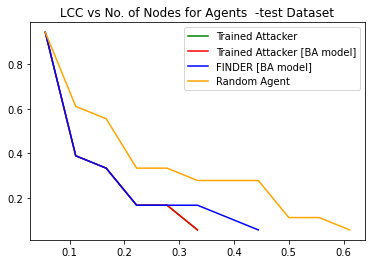

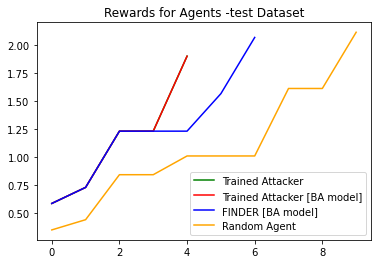

Trained Attacker [4, 26, 0, 5, 27, 8, 9, 20, 3, 1, 45, 33, 48, 14, 32, 16, 21, 10, 39]
Trained Attacker [BA model] [19, 6, 5, 4, 10, 26, 33, 39, 0, 27, 3, 45, 48, 1, 8, 9, 28, 14, 32, 38, 21]
FINDER [BA model] [40, 43, 4, 26, 0, 8, 20, 1, 35, 9, 32, 45, 5, 3, 27, 33, 48, 29, 49, 28, 10, 23, 21, 36, 14, 16, 42, 31, 41, 15, 6, 37]


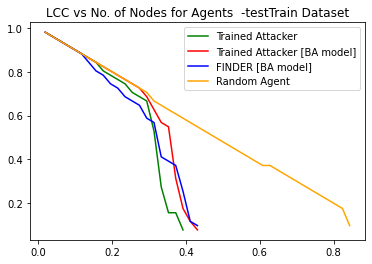

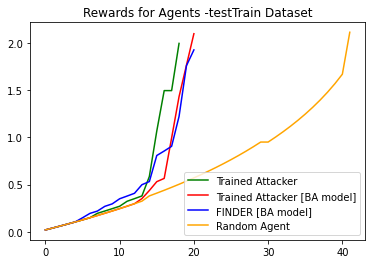

Trained Attacker [71, 99, 124, 22, 127, 58, 133, 96, 32, 119, 101, 183, 1, 100, 47, 117, 120, 192, 126, 129, 27, 112, 4, 91, 164, 24, 92, 165, 93, 166, 38, 94, 167, 44, 95, 168, 97, 169, 73, 98, 170, 102, 171, 103, 172, 69, 104, 173, 82]
Trained Attacker [BA model] [91, 92, 93, 94, 95, 97, 98, 102, 99, 124, 103, 104, 164, 105, 165, 106, 166, 107, 167, 108, 184, 168, 109, 185, 110, 169, 111, 170, 113, 171, 114, 172, 115, 173, 116, 58, 118, 22, 174, 48, 121, 186, 128, 51, 14, 175, 130, 33, 52, 38, 122, 49, 176, 53, 123, 177, 50, 44, 54, 125, 178, 55, 131, 60, 15, 179, 57, 16, 132, 62, 27, 59, 180, 134, 63, 135, 181, 61, 1, 100, 64, 65, 182, 117, 183, 67, 66, 240, 96, 78, 0, 70, 19, 241, 83, 17, 187, 242, 2, 200, 20, 72, 243, 82, 152, 188, 119, 18, 3, 260, 21, 74, 201, 155, 261, 5, 189, 120, 25, 127, 142, 75, 213, 207, 23, 4, 190, 85, 26, 192, 203, 76, 86, 29, 87, 28, 136, 244, 24, 71, 211, 79, 151, 6, 34, 137, 232, 252, 202, 80, 214, 191, 126, 204, 7, 36, 101, 138, 212, 233, 253, 81, 228

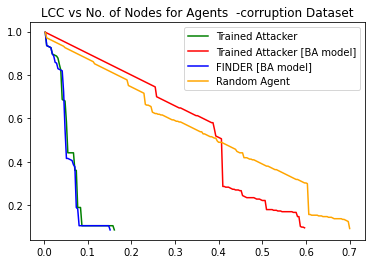

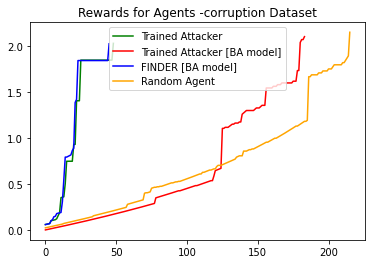

Trained Attacker [52, 49, 69, 38, 55, 50, 31, 54, 93, 28, 47, 66, 101, 68, 40, 102, 33, 29, 114, 71, 123, 34, 39, 87, 119, 100, 86, 35, 27, 51, 88, 67, 74, 72, 30, 94, 17, 95, 0, 124, 56, 2, 103, 80, 14, 21, 22, 23, 32, 125, 73, 61, 42, 41, 18, 85, 36, 53, 26, 64, 25, 24, 37, 48, 127, 62, 91, 20, 77, 104, 84, 122, 9, 16, 65]
Trained Attacker [BA model] [100, 124, 109, 101, 49, 102, 123, 73, 68, 74, 114, 54, 86, 87, 47, 71, 88, 69, 34, 61, 39, 66, 55, 93, 38, 52, 35, 31, 85, 33, 119, 24, 28, 122, 30, 40, 21, 36, 62, 50, 22, 37, 23, 107, 53, 105, 27, 108, 76, 32, 48, 113, 26, 127, 42, 25, 56, 126, 99, 51, 106, 18, 67, 29, 57, 78, 103, 0, 16, 104, 58, 84, 15, 75, 46, 19, 17, 43, 65, 20, 59, 125, 8, 63, 44, 41, 77, 80, 60, 64]
FINDER [BA model] [64, 17, 54, 38, 49, 50, 55, 69, 31, 28, 93, 29, 66, 40, 101, 68, 47, 102, 33, 52, 51, 114, 71, 119, 100, 34, 123, 87, 86, 39, 35, 88, 74, 27, 67, 30, 32, 72, 124, 94, 61, 95, 56, 73, 0, 22, 23, 21, 26, 42, 125, 41, 80, 18, 25, 103, 85, 36, 24, 53, 

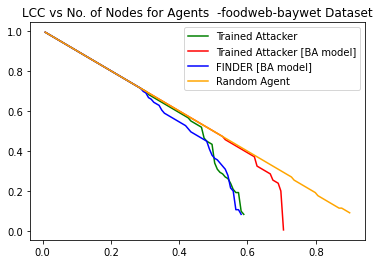

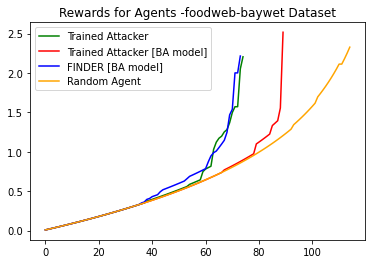

Trained Attacker [25, 74, 72, 56, 62, 67, 57, 23, 24, 27, 54, 26, 76, 60, 124, 73, 28, 5, 129, 152, 134, 120, 126, 22, 61, 66, 50, 77, 127, 3, 68, 55, 52, 135, 75, 10, 125, 133, 37, 29, 123, 319, 53, 63, 51, 65, 213, 47, 49, 4, 44, 64, 78, 100, 106, 110, 115, 200, 204, 46, 104, 130, 137]
Trained Attacker [BA model] [120, 134, 127, 66, 52, 124, 60, 135, 75, 77, 50, 126, 76, 65, 59, 129, 54, 64, 73, 24, 125, 69, 152, 57, 68, 28, 61, 133, 70, 72, 26, 115, 137, 123, 319, 23, 42, 141, 130, 154, 40, 63, 62, 67, 5, 27, 56, 53, 55, 205, 200, 22, 74, 106, 100, 3, 25, 104, 10, 29, 37, 286, 202, 46, 78, 4, 110, 43, 49]
FINDER [BA model] [74, 25, 3, 62, 56, 67, 72, 27, 57, 23, 26, 24, 73, 5, 76, 152, 28, 54, 124, 60, 22, 129, 61, 126, 120, 134, 68, 66, 50, 77, 55, 127, 10, 52, 135, 125, 123, 29, 133, 75, 53, 37, 319, 63, 213, 51, 65, 137, 47, 110, 78, 4, 106, 64, 44, 204, 200, 49, 104, 209, 46, 94, 207, 293, 205, 130, 59, 100, 112, 202, 290, 286, 43, 172, 70, 328, 146, 189, 154, 115, 141, 79, 80, 

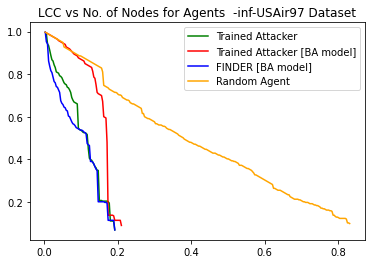

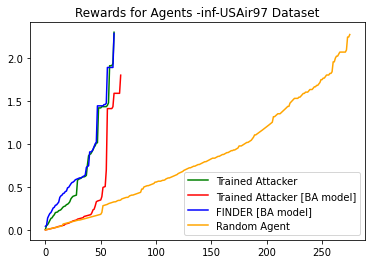

Trained Attacker [103, 0, 19, 120, 131, 115, 130, 273, 180, 64, 162, 339, 102, 149, 338, 51, 375, 21, 78, 432, 57, 175, 195, 213, 414, 503, 23, 136, 188, 214, 270, 283, 467, 81, 445, 14]
Trained Attacker [BA model] [103, 120, 340, 161, 181, 183, 336, 213, 185, 21, 337, 186, 115, 135, 341, 19, 184, 139, 0, 342, 285, 24, 140, 223, 9, 172, 343, 106, 142, 272, 286, 132, 18, 182, 107, 218, 130, 344, 243, 23, 287, 262, 64, 108, 164, 109, 131, 273, 345, 219, 351, 244, 288, 180, 78, 51, 432, 110, 263, 467, 148, 346, 562, 231, 38, 375, 189, 220, 245, 352, 434, 102, 318, 414, 195, 289, 1, 137, 267, 149, 227, 81, 347, 563, 445, 31, 190, 221, 428, 450, 246, 66, 353, 479, 503]
FINDER [BA model] [0, 273, 19, 103, 64, 131, 130, 120, 180, 375, 115, 162, 51, 149, 503, 432, 78, 414, 102, 339, 195, 57, 338, 270, 81, 445, 136, 21, 450, 399, 467, 302, 227, 283, 175, 214, 213, 108, 23, 31, 188, 172, 14, 272, 271, 590, 114, 344, 350, 176, 71, 126, 203, 184, 182, 321, 342, 346, 347, 343, 340, 345, 337, 15, 93

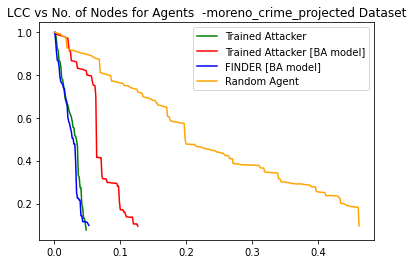

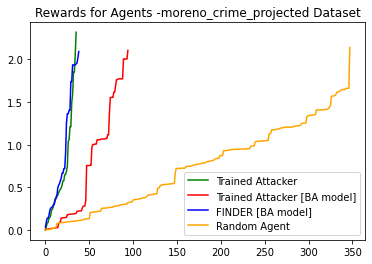

Trained Attacker [37, 41, 43, 347, 38, 111, 48, 84, 53, 99, 370, 91, 348, 40, 106, 497, 210, 47, 85, 503, 42, 103, 45, 399, 36, 403, 44, 118, 357, 351, 9, 107, 46, 81, 360, 73, 8, 93, 346, 98, 6, 491, 94, 104, 504, 412, 430, 97, 352, 525, 400, 488, 492, 426, 120, 12, 95, 514, 243, 359, 234, 105, 349, 193, 59, 7, 119, 186, 391, 477, 390, 549, 353, 696, 76, 191, 394, 367, 74, 402, 185, 786, 502, 512, 58, 698, 35, 52, 163, 362, 361, 34, 39, 479, 350, 167, 369, 416, 877, 513, 135, 531, 136, 427, 464, 493, 192, 1319, 425, 550, 559, 10, 96, 548, 449, 1613, 354, 410, 673, 184, 405, 87, 1331, 401, 80, 584, 345, 180, 358, 72, 515, 1879, 498, 701, 554, 759, 432, 1410, 534, 90, 116, 586, 489, 788, 407, 1, 588, 51, 83, 88, 518, 750, 1540, 873, 519, 1523, 1502, 165, 112, 102, 13, 79, 78, 100, 113, 178, 214, 117, 49, 909, 414, 2810, 379, 481, 597, 494, 363, 419, 377, 440, 1198, 589, 1332, 524, 468, 668, 682, 538, 92, 89, 418, 114, 540, 476, 465, 697, 913, 1081, 836, 921, 475, 170, 420, 60, 478, 486,

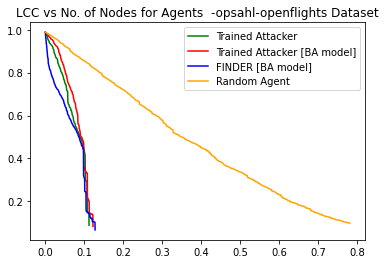

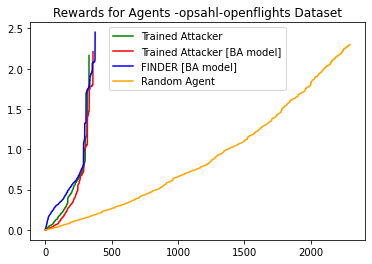

Trained Attacker [30, 23, 33, 32, 13, 17, 21, 141, 40, 80, 34, 48, 97, 25, 357, 276, 223, 87, 112, 31, 53, 58, 9, 88, 54, 168, 196, 61, 74, 73, 115, 124, 103, 204, 481, 6, 222, 93, 138, 24, 79, 145, 167, 91, 128, 12, 140, 166, 202, 15, 55, 164, 137, 170, 240, 18, 101, 146, 162, 228, 295, 353, 19, 37, 49, 102, 152, 326, 379, 20, 45, 82, 83, 184, 224, 36, 43, 57, 143, 209, 625, 114, 185, 365, 38, 94, 172, 199, 310, 382, 51, 63, 64, 183, 299, 484, 488, 2, 109, 127, 133, 239, 253, 286, 298, 70, 108, 129, 142, 163, 171, 395, 556, 580, 29, 50, 56, 71, 90, 136, 160, 161, 251, 319, 330, 355, 692, 26, 44, 81, 104, 174, 186, 207, 230, 352, 363, 377, 388, 390, 394, 437, 478, 22, 47, 52, 67, 68, 78, 92, 121, 126, 130, 153, 193, 197, 211, 217, 246, 275, 289, 324, 329, 380, 426, 561, 627, 675, 8, 10, 60, 98, 135]
Trained Attacker [BA model] [53, 34, 61, 40, 481, 31, 115, 357, 87, 80, 205, 166, 5, 97, 48, 141, 54, 21, 32, 58, 17, 73, 25, 204, 93, 112, 33, 13, 30, 74, 223, 23, 167, 91, 168, 196, 276, 

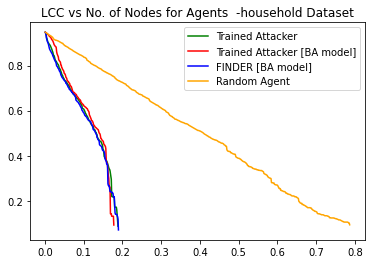

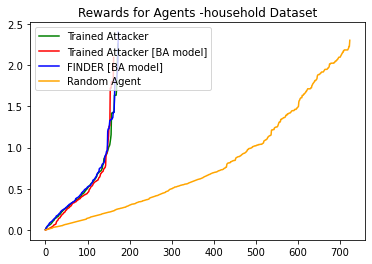

Trained Attacker [522, 47, 91, 27, 275, 485, 23, 124, 760, 76, 208, 5, 142, 164, 586, 706, 129, 297, 959, 4, 132, 283, 547, 708, 687, 820, 20, 32, 39, 95, 169, 284, 15, 35, 131, 338, 537, 1031, 37, 53, 294, 321, 699, 748, 1, 89, 97, 107, 135, 319, 495, 523, 599, 702, 711, 725, 853, 58, 140, 341, 451, 561, 562, 616, 704, 745, 746, 3, 14, 34, 46, 69, 72, 181, 210, 236, 253, 262, 366, 478, 482, 533, 542, 634, 676, 759, 782, 75, 78, 114, 123, 133, 148, 180, 209, 222, 279, 318, 327, 426, 428, 570, 580, 603, 635, 703, 716, 800, 2, 36, 65, 73, 100, 104, 158, 269, 303, 487, 579, 597, 675, 747, 762, 765, 776, 814, 827, 836, 928, 998, 1122, 38, 68, 108, 145, 163, 165, 184, 267, 280, 313, 358, 359, 405, 435, 439, 445, 476, 544, 639, 657, 705, 712, 749, 826, 854, 859, 861, 929, 984, 1075, 1141, 1174, 0, 11, 40, 42, 74, 120, 141, 143, 174, 182, 185, 205, 206, 224, 231, 238, 241, 272, 298, 306, 351, 352, 382, 386, 388, 448, 459, 490, 491, 500, 545, 567, 585, 609, 624, 632, 669, 678, 683, 693, 721, 7

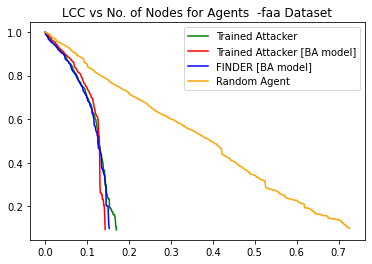

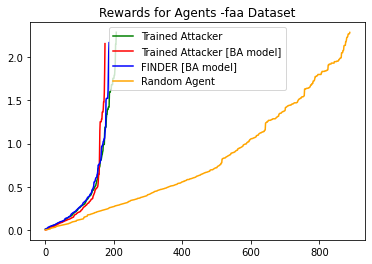

Trained Attacker [289, 288, 290, 287, 291]
Trained Attacker [BA model] [2630, 2531, 290, 2628, 2629, 0, 291, 289, 287, 288]
FINDER [BA model] [289, 288, 287, 0, 2630, 290, 2531, 291, 2629, 2628]


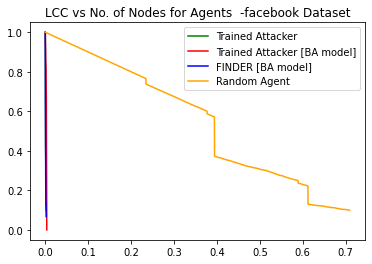

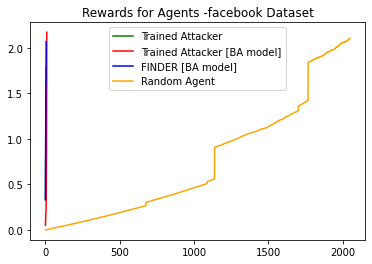

Trained Attacker [191, 1804, 1050, 26, 1, 3138, 756, 39, 442, 869, 3, 2926, 2864, 3789, 560, 122, 2991, 2944, 263, 2997, 4189, 2, 9, 690, 642, 850, 286, 21, 27, 15, 37, 20, 47, 32, 85, 4620, 54, 78, 0, 1773, 586, 75, 636, 3036, 60, 584, 94, 97, 4, 793, 13, 59, 23, 25, 123, 867, 116, 112, 138, 125, 848, 5, 6, 4940, 142, 7, 881, 904, 8, 10, 139, 485, 147, 11, 162, 516, 912, 12, 668, 14, 1090, 16, 211, 17, 22, 235, 24, 785, 253, 18, 174, 871, 1166, 254, 19, 28, 29, 149, 30, 918, 31, 33, 187, 260, 34, 35, 302, 155, 1925, 922, 156, 36, 38, 40, 1258, 41, 42, 960, 346, 1396, 157, 1416, 43, 44, 177, 45, 46, 48, 985, 49, 50, 51, 1552, 188, 52, 2022, 1593, 53, 172, 1080, 233, 1707, 194, 199, 56, 259, 1974, 55, 240, 352, 57, 369, 58, 401, 275, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 2940, 72, 372, 73, 449, 74, 76, 2655, 446, 2913, 1130, 77, 79, 2957, 80, 2969, 81, 2987, 82, 290, 83, 468, 84, 304, 86, 2993, 536, 3124, 1259, 3132, 480, 87, 88, 89, 92, 316, 90, 471, 91, 93, 3271, 95, 96, 98, 99,

FINDER [BA model] [191, 3138, 3789, 1050, 756, 1804, 4189, 2991, 2997, 2944, 869, 2864, 2926, 690, 1773, 4620, 867, 850, 442, 3884, 3036, 4185, 793, 1925, 1166, 2940, 263, 2957, 2022, 904, 3422, 286, 3667, 2913, 4634, 3271, 1593, 4629, 1552, 3132, 636, 4630, 1707, 881, 3683, 848, 122, 2969, 39, 586, 1090, 1396, 4678, 560, 26, 1416, 2655, 668, 642, 1258, 2993, 2987, 1974, 59, 912, 3124, 1818, 4826, 75, 1302, 4187, 584, 1630, 4632, 2888, 3044, 3353, 871, 1566, 1315, 1572, 4358, 960, 922, 785, 1259, 138, 937, 879, 4219, 3050, 3721, 20, 2333, 4633, 1984, 485, 985, 4615, 1080, 1130, 670, 3808, 516, 4110, 3754, 2055, 2187, 1737, 1655, 3191, 934, 2643, 1482, 2979, 4173, 2704, 54, 3894, 188, 536, 1770, 650, 3658, 3826, 1591, 149, 3746, 240, 2081, 2923, 3254, 1092, 4215, 834, 1579, 4517, 177, 998, 3019, 2799, 2954, 2890, 714, 2340, 1979, 174, 2876, 2931, 945, 4475, 468, 2664, 1184, 2962, 4667, 142, 3122, 2137, 4375, 2895, 1683, 3145, 3301, 372, 2971, 1849, 2986, 463, 1250, 1742, 2050, 112, 1847

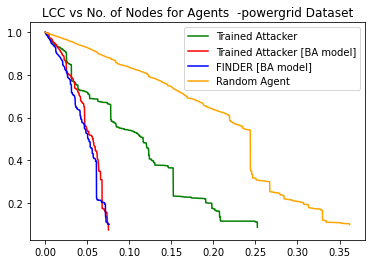

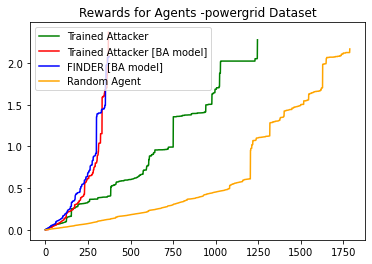

Trained Attacker [44, 133, 45, 645, 945, 46, 202, 239, 946, 947, 206, 170, 604, 944, 48, 296, 948, 286, 949, 54, 82, 603, 950, 85, 217, 273, 606, 951, 49, 153, 243, 285, 310, 354, 537, 718, 952, 1248, 303, 355, 538, 646, 953, 1223, 161, 276, 277, 356, 451, 602, 649, 832, 954, 1055, 87, 111, 169, 240, 245, 305, 327, 452, 557, 955, 971, 1056, 1197, 1224, 1283, 1339, 17, 61, 96, 105, 117, 174, 204, 275, 344, 453, 535, 536, 589, 761, 809, 879, 956, 1057, 1070, 1225, 1246, 1262, 1284, 11, 55, 106, 112]
Trained Attacker [BA model] [46, 45, 604, 44, 239, 451, 1055, 1224, 206, 354, 1246, 645, 133, 603, 452, 1056, 1283, 1225, 945, 946, 947, 944, 948, 949, 950, 951, 952, 953, 954, 955, 286, 48, 202, 170, 277, 355, 1247, 537, 1226, 453, 761, 809, 956, 1057, 1284, 245, 85, 105, 296, 606, 82, 644, 54, 1249, 310, 253, 454, 762, 810, 957, 1058, 1285, 1227, 273, 303, 249, 356, 217, 96, 541, 646, 108, 719, 1248, 870, 190, 139, 611, 240, 243, 1196, 341, 153, 734, 1228, 143, 455, 763, 811, 958, 1033, 105

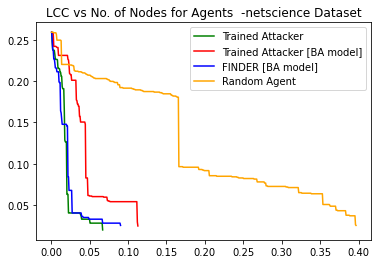

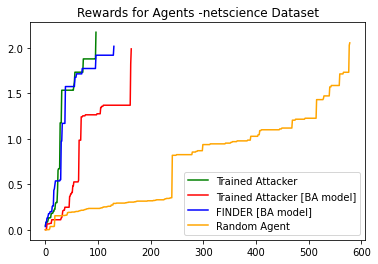

In [40]:
attacker_differentGraph= torch.load('./model/DiffSize_Different_Graph/model_differentGraph_150000')#150000
attacker_BATypeGraph= torch.load('./model/DiffSize_BA_Graph/model_BAGraph_10000')#120000
attacker_ERTypeGraph= None#torch.load('./model/DiffSize_Eros_Graph/model_ErosGraph_10000')
attacker_SWTypeGraph= None#torch.load('./model/DiffSize_SmallWorld_Graph/model_SmallWorldGraph_10000')
'''print("Different Graph")
print("Target")
for param in attacker_differentGraph._target_q_network.parameters():
    print(param)
print("Q Network")att
for param in attacker_differentGraph._q_network.parameters():
    print(param)'''

'''print("Same Type Graph")
print("Target")
for param in attacker_differentGraph._target_q_network.parameters():
    print(param)
print("Q Network")
for param in attacker_differentGraph._q_network.parameters():
    print(param)'''
AUC = visual_evaluation(attacker_differentGraph, attacker_BATypeGraph,attacker_ERTypeGraph,attacker_SWTypeGraph)

In [41]:
print(AUC)
file = ['differentGraph','BAGraph','ERGraph','SWGraph','Finder','Random']
for i in range(AUC.shape[0]):
    best = np.argmin(AUC[i,1:].astype(float))
    print(AUC[i,0],'\t',file[best],'\t',AUC[i,best+1])

[['test' '1.5555555555555554' '1.5555555555555554' 'inf' 'inf'
  '1.8333333333333333' '3.388888888888889']
 ['testTrain' '13.117647058823529' '14.529411764705882' 'inf' 'inf'
  '13.754901960784313' '23.539215686274513']
 ['corruption' '18.967741935483875' '109.90806451612903' 'inf' 'inf'
  '17.874193548387098' '119.43548387096774']
 ['foodweb-baywet' '49.65503875968992' '57.081395348837205' 'inf' 'inf'
  '48.56976744186047' '62.6124031007752']
 ['inf-USAir97' '34.47597597597598' '50.153153153153156' 'inf' 'inf'
  '31.460960960960964' '138.13663663663664']
 ['moreno_crime_projected' '20.720529801324503' '53.127814569536426'
  'inf' 'inf' '19.017218543046354' '182.71258278145697']
 ['opsahl-openflights' '224.062074829932' '244.73554421768708' 'inf'
  'inf' '203.3498299319728' '1121.7690476190476']
 ['household' '103.1344902386117' '103.96366594360089' 'inf' 'inf'
  '101.22505422993493' '367.1366594360087']
 ['faa' '141.83129584352076' '136.4168704156479' 'inf' 'inf'
  '135.9767726161369'

different-150000, BAgraph-120000
[['test' '1.5555555555555554' '1.5555555555555554' 'inf' 'inf'  '1.8333333333333333' '7.777777777777778']
 ['testTrain' '13.117647058823529' '14.450980392156863' 'inf' 'inf'  '13.754901960784313' '22.44117647058823']
 ['corruption' '18.967741935483875' '87.64193548387097' 'inf' 'inf'  '17.874193548387098' '127.11451612903227']
 ['foodweb-baywet' '49.65503875968992' '51.02713178294574' 'inf' 'inf'  '48.56976744186047' '62.12403100775194']
 ['inf-USAir97' '34.47597597597598' '38.40840840840841' 'inf' 'inf'  '31.460960960960964' '139.95795795795794']
 ['moreno_crime_projected' '20.720529801324503' '54.80331125827815' 'inf'  'inf' '19.017218543046354' '190.07350993377486']
 ['opsahl-openflights' '224.062074829932' '523.5333333333333' 'inf' 'inf'  '203.3498299319728' '1155.77193877551']]
test 	 differentGraph 	 1.5555555555555554
testTrain 	 differentGraph 	 13.117647058823529
corruption 	 Finder 	 17.874193548387098
foodweb-baywet 	 Finder 	 48.56976744186047
inf-USAir97 	 Finder 	 31.460960960960964
moreno_crime_projected 	 Finder 	 19.017218543046354
opsahl-openflights 	 Finder 	 203.3498299319728

## FINDER

In [ ]:
'''path = "/home/bhandk/Desktop/MAS/FINDER/MaxCCList_Strategy_"
file_name = ["test","testTrain","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]

for f in file_name:
    fname = path+f+".txt"
    data = np.loadtxt(fname)
    plt.plot(np.arange(len(data)),data,color="blue")
    plt.ylabel("GCC")
    plt.xlabel("Nodes")
    plt.title("JUST FINDER: "+f)
    #plt.savefig("./figure/FINDER_"+f)
    plt.show()'''